In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import xtrack as xt
import xpart as xp
import xcoll as xc
import xobjects as xo

In [2]:
num_particles = 100
num_turns = 1_000_000
max_x = 0.042

In [3]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()

context = xo.ContextCpu()
line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.0e6

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
env = line.env
monitor1 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, n_repetitions=1, repetition_period=10000, particle_id_range=(num_particles-5, num_particles))
# monitor2 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)
# monitor3 = xt.ParticlesMonitor(num_particles=num_particles, start_at_turn=0, stop_at_turn=num_turns)

env.elements['monitor_qd31110'] = monitor1
# env.elements['monitor_qf31010'] = monitor2
# env.elements['monitor_start'] = monitor3
# line.insert([env.place('monitor_qd31110', at='qd.31110@end'), env.place('monitor_qf31010', at='qf.31010@end'), env.place('monitor_start', at=0)])
line.insert([env.place('monitor_qd31110', at='qd.31110@end')])

Slicing line:   0%|          | 0/3848 [00:00<?, ?it/s]

In [86]:
def straight_curve(angle, x_max, x_min=0, num_points=100):
    x = np.linspace(x_min, x_max, num_points)
    y = np.tan(angle) * x
    return x, y

In [83]:
np.sin(np.pi/4)

np.float64(0.7071067811865475)

In [87]:
x, y = straight_curve(np.pi/4, max_x, num_points=num_particles)

In [89]:
part2 = line.build_particles(x=x, y=y, zeta=np.ones(num_particles) * tw.particle_on_co.zeta, delta=np.ones(num_particles) * tw.particle_on_co.delta)

In [46]:
x, y = straight_curve(np.pi/4, max_x, num_points=num_particles)
part = line.build_particles(x=x, y=y)
part.delta = tw.particle_on_co.delta
part.zeta = tw.particle_on_co.zeta

In [72]:
x_ext = np.linspace(-0.0415, 0.0415, 10)
y_ext = np.linspace(-0.0415, 0.0415, 10)
X, Y = np.meshgrid(x_ext, y_ext, indexing='xy')
part_init = line.build_particles(x=X.flatten(), y=Y.flatten())
part_init.delta = tw.particle_on_co.delta
part_init.zeta = tw.particle_on_co.zeta

In [73]:
part_init.x[49]

np.float64(0.0415)

In [6]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

line.track(part, num_turns=num_turns, time=True, with_progress=True)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/1000000 [00:00<?, ?it/s]

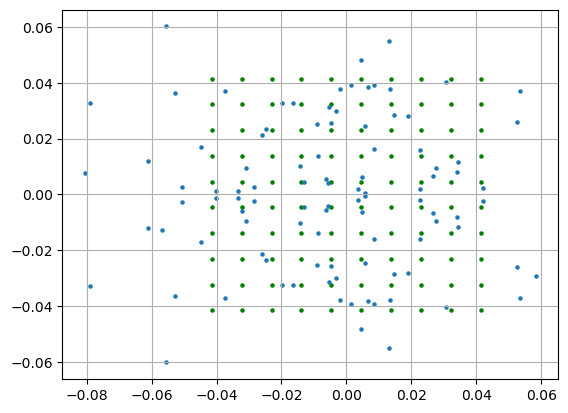

In [57]:
fig, ax = plt.subplots()
ax.scatter(X,Y, s=5, color='green')
ax.scatter(part.x, part.y, s=5)
ax.grid()

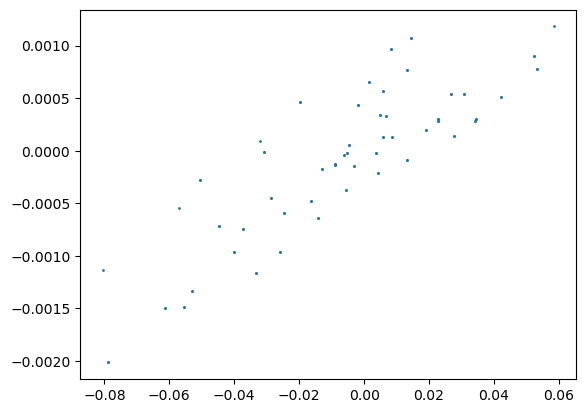

In [13]:
fig, ax = plt.subplots()
# ax.scatter(X,Y, s=1, color='green')
ax.scatter(part.x, part.px, s=1)

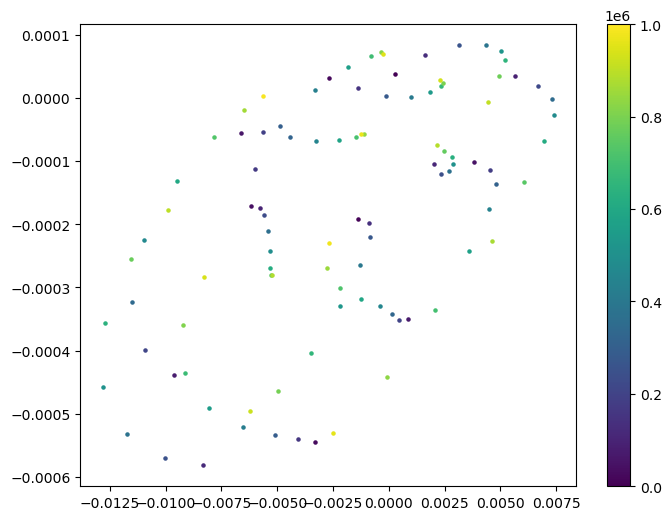

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# ax.scatter(X,Y, s=1, color='green')
cmap = plt.get_cmap('viridis')
for turn in range(num_turns//10000):
    ax.scatter(monitor1.x[0,turn*10000], monitor1.px[0,turn*10000], s=5, color=cmap(turn/(num_turns//10000)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.Normalize(vmin=0, vmax=num_turns))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
# ax.scatter(monitor1.x[:,-1], monitor1.px[:,-1], s=5)

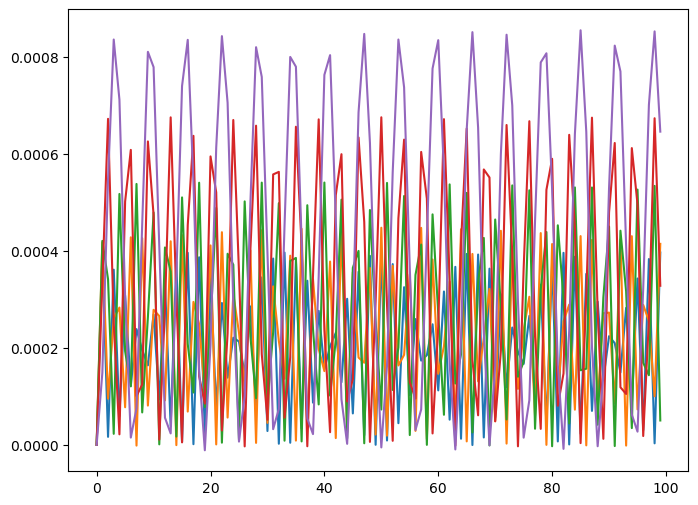

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for pid in range(5):
    ax.plot(monitor1.delta[pid,::10000], label=f'Particle {pid}')

In [34]:
means = [monitor1.x[:,turn].mean() for turn in range(num_turns)]
stds = [monitor1.x[:,turn].std() for turn in range(num_turns)]

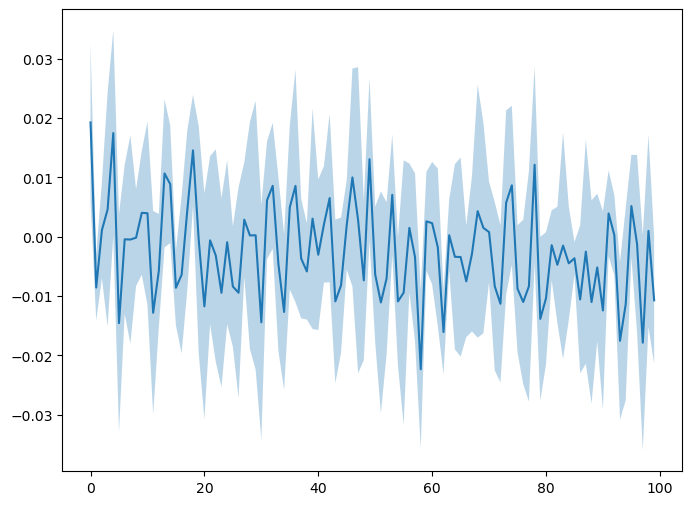

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot([means[i*10000] for i in range(num_turns//10000)])
ax.fill_between(range(num_turns//10000), 
                [means[i*10000]-stds[i*10000] for i in range(num_turns//10000)],
                [means[i*10000]+stds[i*10000] for i in range(num_turns//10000)],
                alpha=0.3)

In [55]:
means[11000]

np.float64(-0.0037922594302859324)

In [18]:
monitor1.x[0,:]

array([ 0.00030121,  0.00436296, -0.00313027, ..., -0.00783939,
       -0.00049458,  0.00419915], shape=(1000000,))

In [70]:
np.argmin(part.x)

np.int64(49)

In [71]:
part.particle_id[49]

np.int64(49)

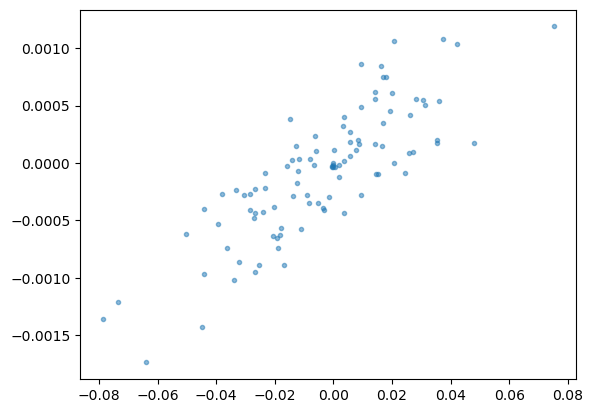

In [48]:
fig, ax = plt.subplots()
ax.plot(part.x, part.px, '.', alpha=0.5)

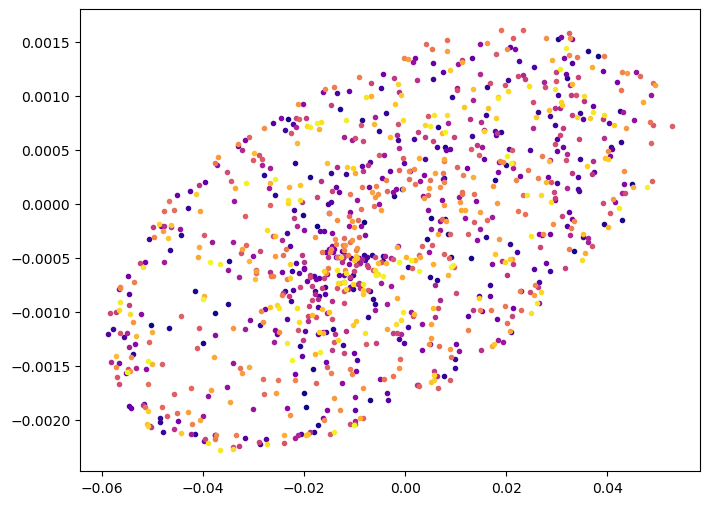

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
cmap = plt.get_cmap('plasma')
for turn in range(0, 999):
    ax.plot(monitor1.x[4, turn], monitor1.px[4, turn], '.', color = cmap(turn/1000))

# ax.plot(monitor1.x[99], monitor1.px[99], '.', alpha=0.5)

In [27]:
np.min(monitor1.x[99, :]), np.max(monitor1.x[99, :])

(np.float64(-0.059938538435136884), np.float64(0.05366788470521578))

In [29]:
np.mean(monitor1.x[99, :]), np.std(monitor1.x[99, :])

(np.float64(-0.0007350541703107416), np.float64(0.010513183187438975))

In [33]:
len(np.where(monitor1.x[99, :] < 0)[0])

91469

In [35]:
len(np.where(monitor1.x[99, :] > 0)[0])

68931

In [36]:
monitor1

ParticlesMonitor(start_at_turn=np.int64(0), stop_at_turn=np.int64(1000000), part_id_start=np.int64(0), part_id_end=np.int64(100), ebe_mode=np.int64(0), n_records=np.int64(100000000), n_repetitions=np.int64(1), repetition_period=np.int64(10000), flag_auto_to_numpy=np.int64(1), data=Particles(_capacity=np.int64(0), _num_active_particles=np.int64(0), _num_lost_particles=np.int64(0), start_tracking_at_element=np.int64(0), q0=0, mass0=0, t_sim=0, _p0c=array([2.592e+10, 2.592e+10, 2.592e+10, ..., 0.000e+00, 0.000e+00,
       0.000e+00], shape=(100000000,)), _gamma0=array([27.64334239, 27.64334239, 27.64334239, ...,  0.        ,
        0.        ,  0.        ], shape=(100000000,)), _beta0=array([0.99934547, 0.99934547, 0.99934547, ..., 0.        , 0.        ,
       0.        ], shape=(100000000,)), s=array([2658.90537929, 2658.90537929, 2658.90537929, ...,    0.        ,
          0.        ,    0.        ], shape=(100000000,)), zeta=array([-1.12023724e-11, -4.05958612e-11, -6.90756614e-11,

In [37]:
monitor1.x[:,0]

array([-3.67864196e-14,  4.59670061e-04,  9.18005816e-04,  1.37500097e-03,
        1.83064919e-03,  2.28494413e-03,  2.73787941e-03,  3.18944862e-03,
        3.63964536e-03,  4.08846321e-03,  4.53589572e-03,  4.98193647e-03,
        5.42657903e-03,  5.86981697e-03,  6.31164386e-03,  6.75205332e-03,
        7.19103896e-03,  7.62859441e-03,  8.06471335e-03,  8.49938949e-03,
        8.93261655e-03,  9.36438831e-03,  9.79469861e-03,  1.02235413e-02,
        1.06509104e-02,  1.10767997e-02,  1.15012035e-02,  1.19241158e-02,
        1.23455308e-02,  1.27654428e-02,  1.31838461e-02,  1.36007352e-02,
        1.40161047e-02,  1.44299492e-02,  1.48422634e-02,  1.52530422e-02,
        1.56622806e-02,  1.60699736e-02,  1.64761165e-02,  1.68807046e-02,
        1.72837334e-02,  1.76851985e-02,  1.80850956e-02,  1.84834207e-02,
        1.88801698e-02,  1.92753391e-02,  1.96689251e-02,  2.00609244e-02,
        2.04513336e-02,  2.08401496e-02,  2.12273697e-02,  2.16129911e-02,
        2.19970113e-02,  

array([-3.50390088e-11, -2.82251823e-04, -4.63768286e-04, -4.35191470e-04,
       -8.13394114e-05,  7.03831200e-04,  1.98316333e-03,  3.72758630e-03,
        5.76364621e-03,  7.70866620e-03,  8.88727969e-03,  8.39103960e-03,
        5.52819547e-03,  2.82228627e-04, -6.56445171e-03, -1.25251790e-02,
       -1.37988025e-02, -8.85870311e-03,  2.05319627e-03,  1.42240146e-02,
        1.68066995e-02,  5.73499447e-03, -1.19326822e-02, -2.01673302e-02,
       -8.47269745e-03,  1.65850028e-02,  1.93666881e-02, -5.98386483e-03,
       -2.41668400e-02, -5.13482126e-03,  2.61344831e-02,  3.33564140e-03,
       -2.71149623e-02, -1.49609237e-03,  2.81810068e-02, -1.57881370e-02,
       -2.07328079e-02,  3.11387203e-02, -1.41923365e-02, -1.78597555e-02,
        3.05168409e-02, -2.33279303e-02, -3.53609612e-03,  2.00599837e-02,
       -3.61823469e-02,  3.59231465e-02, -2.84586542e-02,  1.44816502e-02,
       -6.40953625e-03, -1.09652190e-02,  9.30738552e-03, -1.93950063e-02,
        1.42648418e-02, -

In [55]:
import apertls

In [58]:
line2 = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [59]:
ap_calc = apertls.ApertureCalculator(line2)
x_ext = ap_calc.compute_x_extent()
y_ext = ap_calc.compute_y_extent()

In [76]:
np.min(x_ext[:,1])

np.float64(0.0315)

In [77]:
np.min(y_ext[:,1])

np.float64(0.01615)

In [80]:
dict_monitor={'x' : monitor1.x.tolist(), 'y' : monitor1.y.tolist(), 'px' : monitor1.px.tolist(), 'py' : monitor1.py.tolist(), 'zeta' : monitor1.zeta.tolist(), 'delta' : monitor1.delta.tolist(), 'state': monitor1.state.tolist()}

In [81]:
dict_particles = {'x' : part_init.x.tolist(), 'y' : part_init.y.tolist(), 'px' : part_init.px.tolist(), 'py' : part_init.py.tolist(), 'zeta' : part_init.zeta.tolist(), 'delta' : part_init.delta.tolist(), 'particle_id': part_init.particle_id.tolist(), 'state': part_init.state.tolist(), 'at_element': part_init.at_element.tolist(), 'at_turn': part_init.at_turn.tolist()}

In [97]:
num_turns = 10_000_000
num_particles = 1000

line2 = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, particle_id_range=(num_particles-100, num_particles))
env = line2.env
env.elements['monitor_start'] = monitor
line2.insert([env.place('monitor_start', at=0)])

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           


KeyboardInterrupt: 

In [98]:
import json
with open(f'dynamic_aperture_mon.json', 'w') as fout:
    json.dump(dict_monitor, fout)

In [101]:
with open(f'dynamic_aperture_mon.json', 'r') as f:
    data = json.load(f)